## Recurrent Neural Networks in PyTorch

The Recurrent Neural Network (RNN) Architecture, which can actually be seen as a strict generalization of standard MLPs is, alongside Convolutional Neural Networks, one of the classic Architectures of Neural Networks. 

In some sense, RNN's introduce a time component into the Neural Network by not needed to compute data in a single forward pass. For a basic Introduction see https://en.wikipedia.org/wiki/Recurrent_neural_network.

They also have many interesting Theoretical properties, like being able to model any Computable function :O  which we will not focus on. Because it is so widely used, there already exists a PyTorch implementation. 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
class basicRNN(nn.Module):
    def __init__(self, input_dim,hidden_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.act_hidden = nn.Tanh()
                
        self.in_hidden = nn.Parameter(torch.randn(hidden_dim,input_dim))
        self.hidden_hidden = nn.Parameter(torch.randn(hidden_dim,hidden_dim))
        self.hidden_out = nn.Parameter(torch.randn(output_dim,hidden_dim))
    
    def forward(self, x, h_t = None): 
        if h_t is None: 
            h_t = torch.zeros(self.hidden_dim) 
        
        out = []
        for t in range(x.size(0)):
            x_t = x[t] # value at current time-step
            h_next = self.act_hidden(self.in_hidden @ x_t + self.hidden_hidden @ h_t)
            y = self.hidden_out @ h_next
            out.append(y)
        out = torch.stack(out, dim = 0)
        return out, h_next   
    
#lets define our model
hidden_dim = 15
model = basicRNN(1, hidden_dim,1)
lossfunction = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.01)         
for p in model.parameters():
    print(p.shape)

torch.Size([15, 1])
torch.Size([15, 15])
torch.Size([1, 15])


### Training a Recurrent Neural Network

RNN's are particularly strong on tasks involving time, or other sequential data like text. We will give an example how one can train an RNN on time-series data, namely some stock ticker. For that, we will use the `yfinance` library https://pypi.org/project/yfinance/. Firstly, we will have to transform our our time-series we are given by `yfinance` into a suitable dataset with lables.

In [3]:
def create_dataset(time_series, seq_length):
        x,y = [], []
        for i in range(len(time_series)-seq_length):
            x.append(time_series[i:i+seq_length])
            y.append(time_series[i+seq_length])
        return torch.tensor(np.array(x), dtype=torch.float32), torch.tensor(np.array(y), dtype=torch.float32)
    
ticker = "AAPL" 
start = "2021-01-01"
end = "2025-01-01"
data = yf.download(ticker, start, end)
#Lets only look at the closing prices at the end of each day 
data = data["Close"].values
normconst1 = np.max(data) - np.min(data)
nomrconst2 = np.min(data)
data = (data - np.min(data)) / (np.max(data) - np.min(data))  # Normalize our data for stability

#seqlength is essentially the amount of time-steps we look at in each iteration, this directly corresponds to the hidden_dims as our hidden state
seq_length = 15
inputs, labels = create_dataset(data, seq_length)


split_size = int(len(inputs) * 0.8)
inputs_train, inputs_test = inputs[:split_size], inputs[split_size:]
labels_train, labels_test = labels[:split_size], labels[split_size:]

in_hidden_gradients = []
hidden_hidden_gradients = []
hidden_out_gradients = []
iterations = 500
for epoch in range(iterations):
    model.zero_grad()  
    
    total_loss = 0
    for i in range(inputs_train.shape[0]): 
        x = inputs_train[i]  
        x = x.unsqueeze(-1)  # Unsqueeze to get the shape (seq_length, 1)
        
        output, _ = model(x)  
        
        loss = lossfunction(output, labels_train[i].unsqueeze(-1).unsqueeze(-1))
        total_loss += loss.item()  

        loss.backward()
    for i, p in enumerate(model.parameters()):
        if p.grad is not None:
            if i == 0:
                in_hidden_gradients.append(p.grad)
            elif i == 2: 
                hidden_hidden_gradients.append(p.grad)
            else:
                hidden_out_gradients.append(p.grad)
        
    optimizer.step() 

    # Print loss every 1000 epochs
    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{iterations}], Loss: {total_loss / inputs_train.shape[0]}")

[*********************100%***********************]  1 of 1 completed
c:\Users\JoCraft\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [0/500], Loss: 1.5287112934053924
Epoch [100/500], Loss: 0.0029892952802629685
Epoch [200/500], Loss: 0.0029181830562109356
Epoch [300/500], Loss: 0.0028491876503473827
Epoch [400/500], Loss: 0.0027862477753971154


We got an average loss of 0.816975474357605 on our test set.


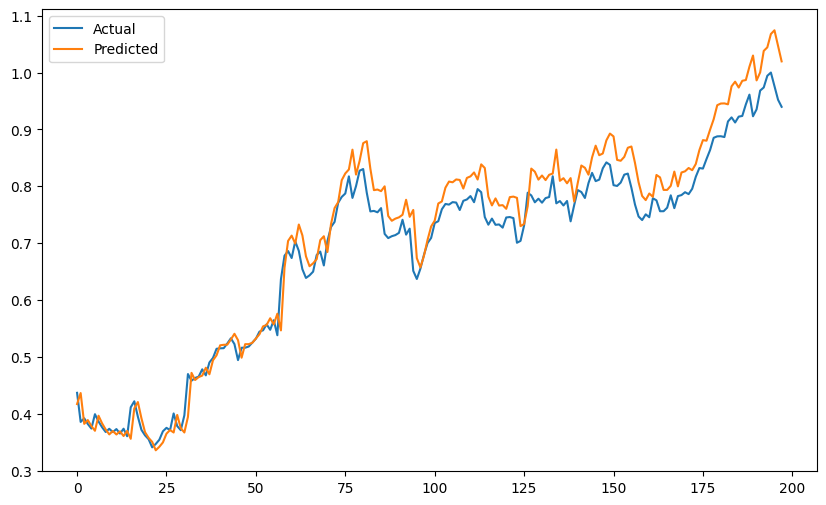

In [4]:
outputs = []
test_loss = 0
for i in range(inputs_test.shape[0]):
    x = inputs_test[i]
    x = x.unsqueeze(-1)
    output, _ = model(x)
    outputs.append(output)
    test_loss += lossfunction(output, labels_test[i].unsqueeze(-1).unsqueeze(-1))

outputs = torch.stack(outputs, dim=0).squeeze()


print(f"We got an average loss of {test_loss} on our test set.")

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(range(len(labels_test)), labels_test.numpy(), label="Actual")
plt.plot(range(len(outputs)), outputs[:,[-1]].detach().numpy(), label="Predicted")
plt.legend()
plt.show()

torch.Size([198])
torch.Size([198, 15])
torch.Size([198, 15])


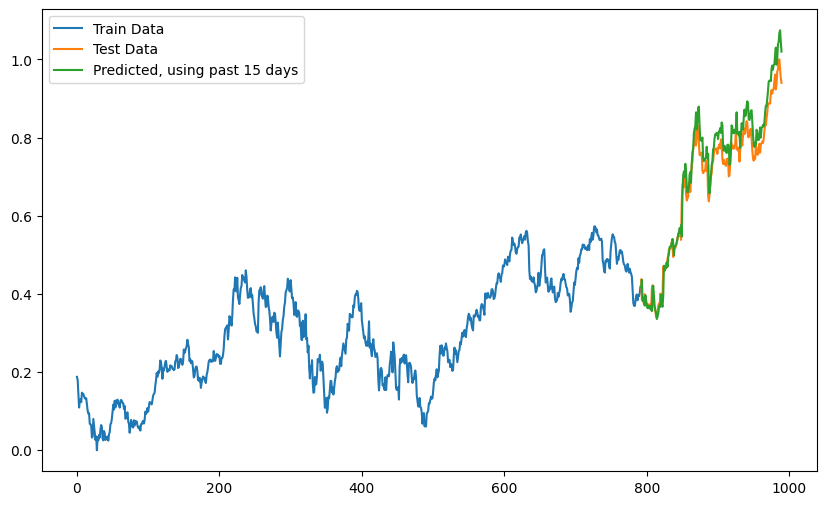

In [5]:
length_train= len(labels_train.detach().numpy())

print(labels_test.shape)
print(inputs_test.shape)
print(outputs.shape)

plt.figure(figsize=(10, 6))
plt.plot(range(length_train), labels_train.detach().numpy(), label="Train Data")
plt.plot(range(length_train, length_train+len(labels_test.detach().numpy())), labels_test.detach().numpy(), label = "Test Data")
#we take -1, as that is the sequence of values we predict to be the next value, based on the history of length seq_length we can look at, in general outputs[:, [i]] the model take the past i+1 days into account to make a prediction
plt.plot(range(length_train, length_train+len(labels_test.detach().numpy())), outputs[:,[-1]].detach().numpy(), label=f"Predicted, using past {seq_length} days")
plt.plot()
plt.legend()
plt.show() 